In [ ]:
# fbg predicted value is used as a feature for classfication of next year status 

In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

warnings.filterwarnings("ignore")
randomseed = 7

Using TensorFlow backend.


In [2]:
x_original = pd.read_csv("../../XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)
x_original=x_original [['Unnamed: 0','L100800','L104600','L103000','S000300','L101700','L100700','FIELD_33',
                       'FIELD_38','FIELD_40','FIELD_31','SEX','AGE', #'CLASS',
                       'FIELD_16','FIELD_23','FIELD_15','FIELD_22','FIELD_17','FIELD_24'
                       ]]

# x_original=x_original [['AGE', 'FIELD_15', 'FIELD_16', 'FIELD_17', 'FIELD_22', 'FIELD_23',
#        'FIELD_24', 'FIELD_31', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'L100500',
#        'L100700', 'L100800', 'L101200', 'L101300', 'L101600', 'L101700',
#        'L103000', 'L103100', 'L103300', 'L104600', 'L107400', 'L190000',
#        'L190300', 'L190400', 'S000300', 'SEX','Unnamed: 0'
#                        ]]


In [3]:
y_original = pd.read_csv("../../TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original=y_original[['Unnamed: 0','CLASS' ,'L100800']]

In [4]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

In [5]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia


print(data.shape)

(169024, 21)


In [6]:
data.columns

Index(['Unnamed: 0', 'L100800_x', 'L104600', 'L103000', 'S000300', 'L101700',
       'L100700', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'SEX', 'AGE',
       'FIELD_16', 'FIELD_23', 'FIELD_15', 'FIELD_22', 'FIELD_17', 'FIELD_24',
       'CLASS', 'L100800_y'],
      dtype='object')

In [7]:
data=data.dropna()

data=data[['L100800_x','L104600', 'L103000', 'S000300', 'L101700', 'L100700',
       'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'SEX', 'AGE','CLASS','L100800_y',]]

# data=data[['AGE', 'FIELD_31', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'L100500',
#        'L100700', 'L100800_x', 'L101200', 'L101300', 'L101600', 'L101700',
#        'L103000', 'L103100', 'L103300', 'L104600', 'L107400', 'L190000',
#        'L190300', 'L190400', 'S000300', 'SEX',
#        'CLASS', 'L100800_y']]
print(data.shape)
data.head()

(56395, 14)


,L100800_x,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,CLASS,L100800_y
2,78.0,5.28,41.0,20.2,15.0,3.8,1.0,2.0,1.0,0.0,1.0,46.0,0,86.0
5,90.0,5.74,50.0,25.5,12.0,3.4,1.0,0.0,1.0,0.0,1.0,52.0,0,88.0
10,86.0,5.83,45.0,21.2,17.0,3.9,1.0,0.0,1.0,1.0,1.0,37.0,0,91.0
11,86.0,4.73,54.0,22.0,30.0,4.2,1.0,2.0,3.0,0.0,1.0,39.0,0,79.0
20,87.0,5.60,340.0,24.6,26.0,4.7,1.0,0.0,2.0,0.0,1.0,59.0,0,93.0


In [8]:
data.groupby(by='CLASS').size()

CLASS
0    38048
1    17305
2     1042
dtype: int64

In [9]:
diabetic = data[data.CLASS == 2]
prediabetic = data[data.CLASS == 1]
normal = data[data.CLASS == 0]

print(diabetic.shape[0], prediabetic.shape[0], normal.shape[0])

1042 17305 38048


In [10]:
diabetic_test = diabetic.sample(200, random_state=randomseed)
prediabetic_test = prediabetic.sample(200, random_state=randomseed)
normal_test = normal.sample(200, random_state=randomseed)
test = pd.concat([diabetic_test, prediabetic_test, normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(
    2 * diabetic_train.shape[0], random_state=randomseed
)
normal_train = normal.drop(normal_test.index).sample(
    2 * diabetic_train.shape[0], random_state=randomseed
)
train = pd.concat([diabetic_train, diabetic_train, prediabetic_train, normal_train])

In [11]:
xtrain = train.iloc[:, :-2]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, :-2]
ytest = test.iloc[:, -1]

In [12]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.transform(xtest)


In [13]:
# xtrain,xtest,ytrain,ytest=train_test_split(data.iloc[:, :-2], data.iloc[:, -1], random_state=42, test_size=0.2)

In [14]:
ytrain.shape

(5052,)

In [15]:
# from imblearn.over_sampling import SMOTE,SMOTENC  # doctest: +NORMALIZE_WHITESPACE

# sm = SMOTENC(random_state=randomseed,categorical_features=[7,8,9,10,11],sampling_strategy='minority')
# X_res, y_res = sm.fit_resample(xtrain, ytrain)

# print("Resampled dataset shape %s" % Counter(y_res))
# print(
#     y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0], y_res[y_res == 2].shape[0]
# )
# print(X_res.shape, y_res.shape)

# xtrain = X_res
# ytrain = y_res


In [16]:
# ypred

In [17]:
# print(list(ytest))

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestRegressor(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)
rf.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=7, verbose=0,
                      warm_start=False)

0.7310608979065161
r2_score 0.7310608979065161


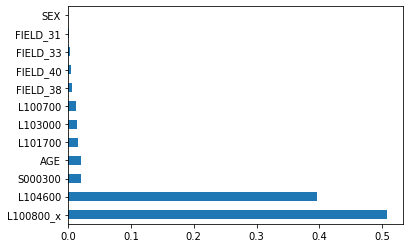

Index(['L100800_x', 'L104600', 'S000300', 'AGE', 'L101700', 'L103000',
       'L100700', 'FIELD_38', 'FIELD_40', 'FIELD_33', 'FIELD_31', 'SEX'],
      dtype='object')


In [19]:
ypred = rf.predict(xtest)
ypred_1008=ypred

score = rf.score(xtest, ytest)
print(score)

print("r2_score", m.r2_score(ytest, ypred))

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-2].columns)
feat_importances.nlargest(24).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(24).index)

In [20]:
xtrain2 = train.iloc[:, :-2]
ytrain2 = train.iloc[:, -2]
xtest2 = test.iloc[:, :-2]
ytest2 = test.iloc[:, -2]

In [21]:
xtrain2['L100800_y']=train.L100800_y
xtest2['L100800_y']=ypred

In [22]:
xtrain2.head()

,L100800_x,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,L100800_y
7453,93.0,5.20,270.0,21.9,50.0,6.7,2.0,2.0,0.0,0.0,0.0,30.0,139.0
7985,204.0,8.70,1016.0,31.0,211.0,7.5,3.0,2.0,0.0,0.0,0.0,31.0,215.0
9422,187.0,9.70,93.0,28.7,27.0,7.1,1.0,2.0,5.0,1.0,0.0,31.0,213.0
10436,116.0,5.75,173.0,29.4,25.0,6.6,1.0,0.0,0.0,1.0,0.0,33.0,136.0
12447,115.0,5.99,41.0,19.6,16.0,4.2,1.0,1.0,0.0,1.0,1.0,34.0,138.0


In [23]:
# from sklearn.preprocessing import MinMaxScaler 
# scaler = MinMaxScaler()
# xtrain2=scaler.fit_transform(xtrain2)
# xtest2=scaler.transform(xtest2)


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)
rf.fit(xtrain2, ytrain2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.7433333333333333


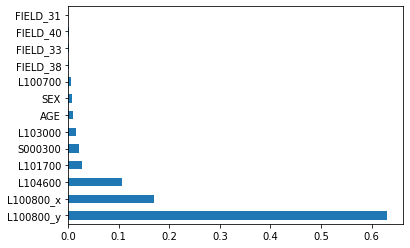

Index(['L100800_y', 'L100800_x', 'L104600', 'L101700', 'S000300', 'L103000',
       'AGE', 'SEX', 'L100700', 'FIELD_38', 'FIELD_33', 'FIELD_40',
       'FIELD_31'],
      dtype='object')


In [25]:
ypred = rf.predict(xtest2)

score = rf.score(xtest2, ytest2)
print(score)

# print("r2_score", m.r2_score(ytest, ypred))

feat_importances = pd.Series(rf.feature_importances_, index=xtest2.columns)
feat_importances.nlargest(24).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(24).index)

In [26]:
# print(feat_importances.nlargest(24))

In [ ]:
ytest=pd.DataFrame(list(ytest),columns=['pred'])
ypred=pd.DataFrame(ypred,columns=['pred'])

conditions = [
    (ypred.pred < 100),
    (ypred.pred >= 100) & (ypred.pred < 126),
    (ypred.pred >= 126),
]

conditions2 = [
    (ytest.pred < 100),
    (ytest.pred >= 100) & (ytest.pred < 126),
    (ytest.pred >= 126),
]

choices = [0, 1, 2]
ypred["CLASS"] = np.select(conditions, choices, default=0)
ytest["CLASS"] = np.select(conditions2, choices, default=0)

ypred=ypred.CLASS.to_numpy()
ytest=ytest.CLASS.to_numpy()

In [ ]:
# print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
# print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

print(m.accuracy_score(ytest,ypred))


confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

In [ ]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=randomseed)

xgb_model.fit(xtrain, ytrain)

y_pred = xgb_model.predict((xtest))

print("r2_score", m.r2_score(ytest, ypred))

In [ ]:
ytest=pd.DataFrame(list(ytest),columns=['pred'])
ypred=pd.DataFrame(y_pred,columns=['pred'])

conditions = [
    (ypred.pred < 100),
    (ypred.pred >= 100) & (ypred.pred < 126),
    (ypred.pred >= 126),
]

conditions2 = [
    (ytest.pred < 100),
    (ytest.pred >= 100) & (ytest.pred < 126),
    (ytest.pred >= 126),
]

choices = [0, 1, 2]
ypred["CLASS"] = np.select(conditions, choices, default=0)
ytest["CLASS"] = np.select(conditions2, choices, default=0)

y_pred=ypred.CLASS.to_numpy()
ytest=ytest.CLASS.to_numpy()

In [ ]:
# y_pred

In [ ]:

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
print(classification_report(ytest, y_pred))

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1,5,10,15,20,25,30,70]}
SVC_clf = SVR()
SVC_clf2 = GridSearchCV(SVC_clf, parameters)
SVC_clf2.fit(xtrain, ytrain)


# sorted(SVC_clf2.cv_results_.keys())

In [ ]:
SVC_clf2.best_estimator_

In [ ]:

SVC_clf = SVC_clf2.best_estimator_
SVC_clf.fit(xtrain, ytrain)

y_pred = SVC_clf.predict((xtest))

In [ ]:
ytest=pd.DataFrame(list(ytest),columns=['pred'])
ypred=pd.DataFrame(y_pred,columns=['pred'])

conditions = [
    (ypred.pred < 100),
    (ypred.pred >= 100) & (ypred.pred < 126),
    (ypred.pred >= 126),
]

conditions2 = [
    (ytest.pred < 100),
    (ytest.pred >= 100) & (ytest.pred < 126),
    (ytest.pred >= 126),
]

choices = [0, 1, 2]
ypred["CLASS"] = np.select(conditions, choices, default=0)
ytest["CLASS"] = np.select(conditions2, choices, default=0)

y_pred=ypred.CLASS.to_numpy()
ytest=ytest.CLASS.to_numpy()

In [ ]:


print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
# multi-class classification with Keras
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import np_utils

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
 
# create model
model = Sequential()
model.add(Dense(64, input_dim=11, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, kernel_initializer='normal', activation='linear'))


# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, xtrain, ytrain, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
history=model.fit(xtrain, np_utils.to_categorical( ytrain.to_numpy()), 
                  epochs=100, batch_size=10,validation_split=.2)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# =====================================

tempdata=data5

diabetic = tempdata[tempdata.CLASS == 2]
prediabetic = tempdata[tempdata.CLASS == 1].sample(diabetic.shape[0],random_state=0)
normal = tempdata[tempdata.CLASS == 0].sample(diabetic.shape[0],random_state=0)

tempdata5=pd.concat([diabetic,prediabetic,normal])
tempdata5.iloc[:, 3:-2]=scaler.transform(tempdata5.iloc[:, 3:-2])

pred5 = rf.predict((tempdata5.iloc[:, 3:-2]))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))

In [ ]:
#xgboost test

In [ ]:
tempdata5Rcolumns=tempdata5.iloc[:, 3:-2]
tempdata5Rcolumns.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
pred5 = xgb_model.predict((tempdata5Rcolumns))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))


In [ ]:
#SVC

In [ ]:
pred5 = SVC_clf.predict((tempdata5.iloc[:, 3:-2]))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))

In [ ]:
# ========================================================

In [ ]:
# import pickle

# with open('_DiabeticClassifierModelForNextYear_rf_model', 'wb') as f:
#     pickle.dump(rf, f)

In [ ]:
# with open('_DiabeticClassifierModelForNextYear_scaler', 'wb') as f:
#     pickle.dump(scaler, f)